In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle, os, corner, glob, sys
from collections import defaultdict
import enterprise.signals.utils as utils
from enterprise.pulsar import Pulsar
from collections import defaultdict
import pandas as pd

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import utils
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import signal_base
from enterprise.signals import selections

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [3]:
import pyne2001
import scipy
from scipy.stats import rv_continuous
from astropy import units as u
from astropy.coordinates import SkyCoord

In [4]:
color_cycle_wong = ['#000000','#E69F00','#009E73','#56B4E9','#0072B2','#F0E442','#D55E00','#CC79A7']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle_wong)

In [5]:
current_path = os.getcwd()
splt_path = current_path.split("/")
#top_path_idx = splt_path.index("akaiser")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [6]:
e_e_path = top_dir + "/enterprise_extensions/"
sys.path.insert(0, e_e_path)
sys.path.insert(0, top_dir + "/enterprise_timing")
import nltm_plot_utils_v2 as nltm

In [7]:
psr_name = 'J1640+2224'#'J1640+2224'#'J2317+1439' 'J1909-3744'
psr_dir = top_dir + '/enterprise_timing/{}/chains/'.format(psr_name)
psrlist = [psr_name]
datareleases = ['11yr','12p5yr']
ephem = 'DE405'

#psrs = nltm.get_psrs(psrlist,datareleases)
#pardict = nltm.get_pardict(psrs,datareleases)
print(psr_dir)

/home/andrew/Documents/Research/nanograv/enterprise_timing/J1640+2224/chains/


In [8]:
datadir = top_dir + "/5yr"
parfiles = sorted(glob.glob(datadir + "/par/*_nltm.par"))
timfiles = sorted(glob.glob(datadir + "/tim/*.tim"))
parfile = [pfile for pfile in parfiles if psr_name in pfile][0]
timfile = [tfile for tfile in timfiles if psr_name in tfile][0]

In [9]:
# filter
is_psr = False
if psr_name in parfile:
    psr = Pulsar(parfile, timfile, ephem=ephem, clk=None, drop_t2pulsar=False)
    is_psr = True

if not is_psr:
    raise ValueError(
        "does not exist in datarelease."
    )

In [10]:
print(psr.t2pulsar.pars()[0:2])
print(psr.t2pulsar.vals()[0:2])

('RAJ', 'DECJ')
[4.36454075 0.39099711]


In [11]:
def px_prior(px,dist,dist_err):
    y = 1/(np.sqrt(2*np.pi)*dist_err*px**2)*np.exp(-(px**(-1)-dist)**2/(2*dist_err**2))
    return y

In [12]:
c = SkyCoord(ra='16:40:16.7435004', dec='22:24:08.94331', unit=(u.hourangle, u.deg))
c_gal = c.transform_to('galactic')

In [13]:
c_gal.l.degree

41.05104415279213

In [14]:
dm_dist = pyne2001.get_dist(c_gal.l.degree,c_gal.b.degree,18.426)[0]
dm_dist

1.16

In [15]:
class NE2001DMDist_gen(rv_continuous):
    "Gaussian distribution"
    def _pdf(self,x, mu, sigma):
        return (1/x**2)*scipy.stats.norm.pdf(x**-1,loc=mu,scale=sigma)

In [16]:
tmp_diste = NE2001DMDist_gen(shapes='mu,sigma')

In [17]:
tmp_diste.pdf(10,mu=1.0,sigma=.2)

7.991870553452739e-07

In [18]:
tmp_diste.rvs(mu=dm_dist,sigma=.2*dm_dist)

0.8252921321004308

import time
num = 10000
tmp_burm_3 = np.zeros(num)
start = time.time()
for i in range(int(num)):
    tmp_burm_3[i] =tmp_diste.rvs(mu=dm_dist,sigma=.2*dm_dist)
    print("\r",end="iter: {} Total time: {}".format(i,time.time()-start),flush=True)

In [19]:
print(np.shape(tmp_burm))
print(min(tmp_burm))
print(np.shape(tmp_burm_1))
print(min(tmp_burm_1))
print(np.shape(tmp_burm_2))
print(min(tmp_burm_2))
print(np.shape(tmp_burm_3))
print(min(tmp_burm_3))

NameError: name 'tmp_burm' is not defined

In [ ]:
tmp_burm_tot = np.concatenate((tmp_burm,tmp_burm_1,tmp_burm_2,tmp_burm_3))
print(tmp_burm_tot.shape)

In [ ]:
#tmp_dist = NE2001DMDistPrior(px,dm_dist,.2*dm_dist)
px = np.linspace(1e-3,10,100)
plt.plot(px,px_prior(px,dm_dist,.2*dm_dist))
plt.plot(px,scipy.stats.norm.pdf(px**-1,loc=dm_dist,scale=.2*dm_dist)/px**2)
plt.plot(px,tmp_diste.pdf(px,mu=dm_dist,sigma=.2*dm_dist))
plt.hist(tmp_burm_tot,density=True,bins=100);
plt.show()

In [ ]:
np.savetxt('px_prior_1.txt', tmp_burm_tot)

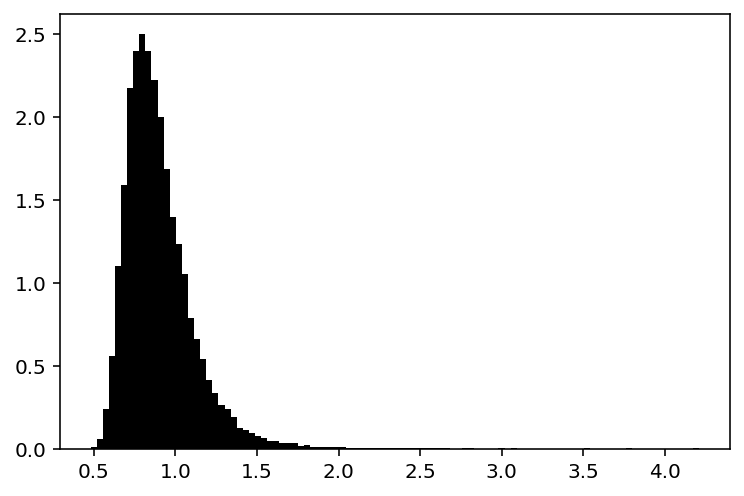

In [20]:
a = np.loadtxt('px_prior_1.txt')
plt.hist(a,density=True,bins=100)
plt.show()

In [ ]:
class NE2001DMDist_rv_gen(rv_continuous):
    "Gaussian distribution"
    def _pdf(self,x, mu, sigma):
        return (1/x**2)*scipy.stats.norm.pdf(x**-1,loc=mu,scale=sigma)
    
def NE2001DMDistPrior(value, mu=1., sigma=.2):
    """Prior function for DE2001 DMDistance parameters."""
    rv_dist = NE2001DMDist_gen(shapes='mu,sigma')
    return rv_dist.pdf(value,mu,sigma)


def NE2001DMDistSampler(mu=1., sigma=.2, size=None):
    """Sampling function for DE2001 DMDistance parameters."""
    rv_dist = NE2001DMDist_gen(shapes='mu,sigma')
    return rv_dist.rvs(mu=mu,sigma=sigma,size=size)

def NE2001DMDist(mu=1., sigma=.2, size=None):
    """Class factory for bounded Normal parameters."""

    class NE2001DMDist(parameter.Parameter):
        _prior = parameter.Function(
            NE2001DMDistPrior, mu=mu, sigma=sigma,
        )
        _sampler = staticmethod(NE2001DMDistSampler)
        _size = size
        _mu = mu
        _sigma = sigma
        _pmin = pmin
        _pmax = pmax

        def __repr__(self):
            return "{}: NE2001DMDist({},{}, [{},{}])".format(
                self.name, mu, sigma, pmin, pmax
            ) + ("" if self._size is None else "[{}]".format(self._size))

    return NE2001DMDist